## Homework02: Neural machine translation and Attention layer.

This notebook accompanies the [week03](https://github.com/ml-mipt/ml-mipt/blob/advanced/week03_NMT_and_attention/week03_seq2seq_NMT_no_bpe.ipynb) practice. Refer to it for more comments.

Your ultimate tast is to enchance the [week03 architecture](https://github.com/ml-mipt/ml-mipt/blob/advanced/week03_NMT_and_attention/week03_seq2seq_NMT_no_bpe.ipynb) for Neural Machine Translation task from German to English.

Your task is to implement the attention layer, modify the Decoder and test your new seq2seq model for machine translation. Code in this notebook refers a lot to the [week03](https://github.com/ml-mipt/ml-mipt/blob/advanced/week03_NMT_and_attention/week03_seq2seq_NMT_no_bpe.ipynb) practical class. You have to modify the network from the class by adding `Attention` module to it.

_Optional: if you wish, you could also try the bidirectional LSTM in the Encoder._


You may leave all the data loading, data preprocessing parts the same as it was in week03 practice.

###  Part 1. Attention

Attention layer can take in the previous hidden state of the decoder, $s_{t-1}$, and all of the stacked forward and backward hidden states from the encoder, $H$. The layer will output an attention vector, $a_t$, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1.

Intuitively, this layer takes what we have decoded so far, $s_{t-1}$, and all of what we have encoded, $H$, to produce a vector, $a_t$, that represents which words in the source sentence we should pay the most attention to in order to correctly predict the next word to decode, $\hat{y}_{t+1}$. 

You can use any type of the attention scores you prefer. We have met at least three of them:

<img src="https://raw.githubusercontent.com/ml-mipt/ml-mipt/advanced/week03_NMT_and_attention/img/scoring_functions.png" />


_Some additional notes coming next:_

First, we calculate the *energy* between the previous decoder hidden state and the encoder hidden states. As our encoder hidden states are a sequence of $T$ tensors, and our previous decoder hidden state is a single tensor, the first thing we do is `repeat` the previous decoder hidden state $T$ times. We then calculate the energy, $E_t$, between them by concatenating them together and passing them through a linear layer (`attn`) and a $\tanh$ activation function. 

$$E_t = \tanh(\text{attn}(s_{t-1}, H))$$ 

This can be thought of as calculating how well each encoder hidden state "matches" the previous decoder hidden state.

We currently have a **[dec hid dim, src sent len]** tensor for each example in the batch. We want this to be **[src sent len]** for each example in the batch as the attention should be over the length of the source sentence. This is achieved by multiplying the `energy` by a **[1, dec hid dim]** tensor, $v$.

$$\hat{a}_t = v E_t$$

We can think of this as calculating a weighted sum of the "match" over all `dec_hid_dem` elements for each encoder hidden state, where the weights are learned (as we learn the parameters of $v$).

Finally, we ensure the attention vector fits the constraints of having all elements between 0 and 1 and the vector summing to 1 by passing it through a $\text{softmax}$ layer.

$$a_t = \text{softmax}(\hat{a_t})$$

This gives us the attention over the source sentence!

Graphically, this looks something like below. This is for calculating the very first attention vector, where $s_{t-1} = s_0 = z$. The green/yellow blocks represent the hidden states from both the forward and backward RNNs, and the attention computation is all done within the pink block.

<img src="https://raw.githubusercontent.com/ml-mipt/ml-mipt/advanced/homeworks/homework2_attention_in_seq2seq/img/seq2seq9.png" />

### Part 2: Decoder with Attention

To make it really work you should also change the`Decoder` class from the classwork in order to make it to use `Attention`. 
You may just copy-paste `Decoder` class and add several lines of code to it.

The decoder contains the attention layer, `attention`, which takes the previous hidden state, $s_{t-1}$, all of the encoder hidden states, $H$, and returns the attention vector, $a_t$.

We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights.

$$w_t = a_t H$$

The input word (that has been embedded), $y_t$, the weighted source vector, $w_t$, and the previous decoder hidden state, $s_{t-1}$, are then all passed into the decoder RNN, with $y_t$ and $w_t$ being concatenated together.

$$s_t = \text{DecoderGRU}(y_t, w_t, s_{t-1})$$

We then pass $y_t$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together.

$$\hat{y}_{t+1} = f(y_t, w_t, s_t)$$

The image below shows decoding the first word in an example translation.

<img src="https://raw.githubusercontent.com/ml-mipt/ml-mipt/advanced/homeworks/homework2_attention_in_seq2seq/img/seq2seq10.png" />

The green/yellow blocks show the forward/backward encoder RNNs which output $H$, the red block shows the context vector, $z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$, the blue block shows the decoder RNN which outputs $s_t$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. Not shown is the calculation of $a_t$.

__All the network parts are stored in `modules.py` in this directory. `Encoder` and `Seq2Seq` classes are already implemented. Please implement `Attention` and `DecoderWithAttention` classes and run the whole training pipeline.__

In [ ]:
# If you are using colab uncomment this cell
 ! wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/advanced/homeworks/homework2_attention_in_seq2seq/modules.py

--2020-04-29 12:14:47--  https://raw.githubusercontent.com/ml-mipt/ml-mipt/advanced/homeworks/homework2_attention_in_seq2seq/modules.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3295 (3.2K) [text/plain]
Saving to: ‘modules.py’

modules.py          100%[===================>]   3.22K  --.-KB/s    in 0s      

2020-04-29 12:14:47 (60.3 MB/s) - ‘modules.py’ saved [3295/3295]



In [ ]:
# Use this to reload the updated `modules.py` file

import modules

import imp
imp.reload(modules)

Encoder = modules.Encoder
Attention = modules.Attention
DecoderWithAttention = modules.DecoderWithAttention
Seq2Seq = modules.Seq2Seq

Here goes Seq2Seq training pipeline (just reusing code from week03).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

! python -m spacy download en
! python -m spacy download de

spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens) and reverses it
    """
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (SRC, TRG))
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)


submission_dataset = next(iter(test_iterator))

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
attention = Attention(HID_DIM, HID_DIM)
dec = DecoderWithAttention(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, HID_DIM, DEC_DROPOUT, attention)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

def init_weights(m):
    # init weights for the nn from uniform distribution (refer to the week03 practice for hint)
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

optimizer = optim.Adam(model.parameters())

PAD_IDX = TRG.vocab.stoi['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output



/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


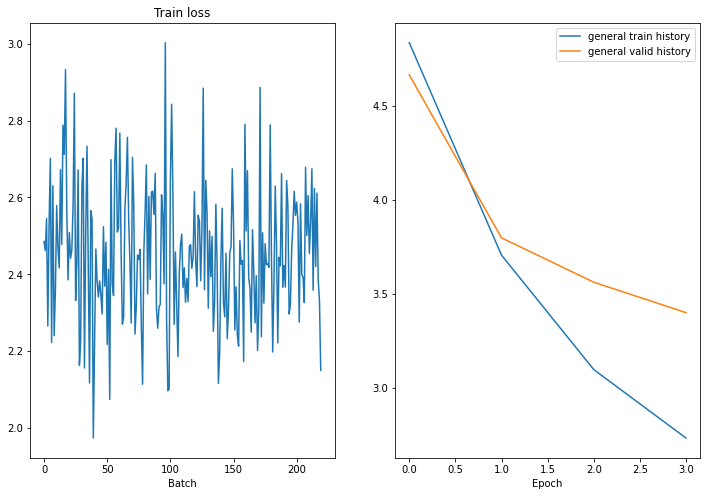

Epoch: 05 | Time: 1m 37s
	Train Loss: 2.452 | Train PPL:  11.611
	 Val. Loss: 3.285 |  Val. PPL:  26.707
| Test Loss: 3.266 | Test PPL:  26.218 |


In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 5
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

model.load_state_dict(torch.load('tut1-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

Compare the results. Write down some thoughts about translation quality. Was attention worth adding to the model?

Let's take a look at some generated translations.

In [ ]:
def generate_translation(trg, output, idx, TRG_vocab):
    original = [TRG_vocab.itos[x] for x in list(trg[:, idx].cpu().numpy())]
    generated = [TRG_vocab.itos[x] for x in list(output[:, idx].cpu().numpy())]
    
    print('Example {}'.format(idx))
    print('Original: {}'.format(' '.join(original)))
    print('Generated: {}'.format(' '.join(generated)))
    print()

In [ ]:
# Do not change me, just run once
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
src = submission_dataset.src
trg = submission_dataset.trg

output = model(src, trg, 0).argmax(dim=2)

submission_dict = {
    'src': src.cpu().numpy(),
    'trg': trg.cpu().numpy(),
    'output': output.cpu().detach().numpy()
}

import pickle
with open('submission_hw2.pcl', 'wb') as iofile:
    pickle.dump(submission_dict, iofile, protocol=4)
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
import numpy as np
for idx in np.random.randint(0, trg.shape[1], 5):
    generate_translation(trg, output, idx, TRG.vocab)

Example 101
Original: <sos> a boy stands with three girls . <eos> <pad> <pad> <pad> <pad> <pad>
Generated: wrists a young boy is with three girls . <eos> <eos> . <eos> <eos>

Example 127
Original: <sos> two men wearing hats . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated: wrists two men with hats are . <eos> <eos> <eos> <eos> <eos> <eos> <eos>

Example 70
Original: <sos> young kids are on a small train ride . <eos> <pad> <pad> <pad>
Generated: wrists young children are riding a a in a . <eos> <eos> <eos> <eos>

Example 62
Original: <sos> a group of people are climbing in cold weather . <eos> <pad> <pad>
Generated: wrists a group of people are climbing on a cold . <eos> <eos> <eos>

Example 118
Original: <sos> dogs run at a dog racetrack . <eos> <pad> <pad> <pad> <pad> <pad>
Generated: wrists dogs dogs on a track . <eos> <eos> <eos> <eos> <eos> <eos> <eos>



Please, upload the `.ipynb` file, `modules.py` file and `submission_hw2.pcl` to the google form to submit the homework.

Please leave feedback (if you wish so ;). Feedback [link](https://forms.gle/KSLdrNxnJUwwieBp9)